# Lab 2 - Feedforward Network and Backpropagation

Objectives:
1. *Understand backpropagation*
2. *Write a neural network with one or more hidden layers*
3. *Solve the XOR*
4. *Understand how to build general classifiers*

During the previous lab we noticed that a single neuron is not able to solve a non-linearly separable problem like the XOR. In this class we will expand the capabilities of our initial network, will move beyond a single neuron and we will solve arbitrarily complex datasets.

## XOR Network
We want to create a network with the following structure:

<center><img src="https://i.imgur.com/wEtR8Jg.png" height="250"></center>

$$s = \vec{w}^T\vec{x}+b$$
$$\sigma(s) = \frac{1}{1+e^{-s}}$$

In [2]:
# Start by importing the library Numpy
import numpy as np

# Create training set.
X = np.random.randint(2, size=[50,2])
Z = np.array([X[:,0] ^ X[:, 1]]).T

# Modify the way weights and bases are initialised
W1 = np.random.randn(3,2)
B1 = np.random.randn(3)
W2 = np.random.randn(1,3)
B2 = np.random.randn(1)

*Can you explain why we set the dimensions of the weights as (3,2) and (1,3)?*

`W1` is the matrix of weights for the first layer, which has 3 neurons, each with 2 inputs. `W2` is the matrix of weights for the second layer, containing only 1 neuron that has 3 inputs.

In [3]:
# Add a forward function to reflect the network topology that we want to replicate

def sigm(X, W, B):
    M = 1/(1+np.exp(-(X.dot(W.T)+B)))
    return M

def Forward(X, W1, B1, W2, B2):
    H = sigm(X,W1,B1) # first layer
    Y = sigm(H,W2,B2) # second layer

    # Return both final and hidden layer output
    return Y, H

Due to the presence of the hidden layer, we need to use the backpropagation algorithm to update the weights.

$$E = (z-y)^2 \\[0.5em]
w_i^\prime = w_i + \eta\frac{dE}{dw_i} \\[0.5em]
b^\prime = b+\eta\frac{dE}{db}
$$

where $z$ is the correct output, $y$ is the current output of the neuron and $\eta$ is the learning rate.

*Try and derive an analytical expression for the update of the weights.*

$s = w_{2,1}h_1 + w_{2,2}h_2 + w_{2,3}h_3 + b_2$

For the second layer: let $y$ = $\sigma(s)$

- First working out `diff_W2`

\begin{split}
    \frac{dE}{dw_{2,i}}
    &= \frac{\partial E}{\partial y} * \frac{\partial y}{\partial s} * \frac{\partial s}{\partial w_{2,i}} \\
    &= -2(z-y) *  y(1-y) * x_{2,i} \\
    &= -2(z-y) *  y(1-y) * h_i
\end{split}

- Then `diff_B2`

\begin{split}
    \frac{dE}{db_2}
    &= \frac{\partial E}{\partial y} * \frac{\partial y}{\partial s} * \frac{\partial s}{\partial b_2} \\
    &= -2(z-y) * y(1-y) * 1
\end{split}

For the first layer: current neuron output now becomes $h_i = \sigma(\bar{h}_i)$

- Deriving `diff_W1`

$$\frac{dE}{dw_{1,i}}
= \frac{\partial E}{\partial \bar{h}_i} * \frac{\partial \bar{h}_i}{\partial w_{1,1}}
= \frac{\partial E}{\partial \bar{h}_i} * x_{1,i}$$

$$\frac{\partial E}{\partial \bar{h}_i}
= \frac{\partial E}{\partial h_i} * \frac{\partial h_i}{\partial \bar{h}_i}
= \frac{\partial E}{\partial h_i} *  h_i(1-h_i)$$

$$\frac{\partial E}{\partial h_i}
= \frac{\partial E}{\partial s} * \frac{\partial s}{\partial h_i}
= \frac{\partial E}{\partial s} * w_{2,i}$$

$$\frac{\partial E}{\partial s} = \frac{\partial E}{\partial y} * \frac{\partial y}{\partial s} = -2(z-y)*y(1-y)$$

-   - Plugging everything back in gives

$$\frac{dE}{dw_{1,i}} = x_{1,i} * -2(z-y) * w_{2,i} * y(1-y) * h_i(1-h_i)$$

- Deriving `diff_B1`

$$\frac{dE}{db_1} = \frac{dE}{dw_{1,i}} \div x_{1,i} = -2(z-y) * w_{2,i} * y(1-y) * h_i(1-h_i)$$

In [4]:
# Write the code for the updates of the various parameters

def diff_B2(Z, Y):
    dB = (Z-Y)*Y*(1-Y)
    return dB.sum(axis=0)

def diff_W2(H, Z, Y): 
    dW = (Z-Y)*Y*(1-Y)
    return H.T.dot(dW)

def diff_W1(X, H, Z, Y, W2):
    dZ = (Z-Y).dot(W2)*Y*(1-Y)*H*(1-H)
    return X.T.dot(dZ)

def diff_B1(Z, Y, W2, H):
    return ((Z-Y).dot(W2)*Y*(1-Y)*H*(1-H)).sum(axis=0)

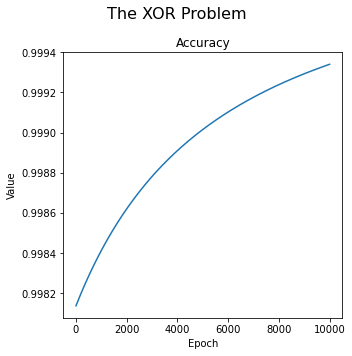

In [7]:
import matplotlib.pyplot as plt

learning_rate = 0.01
acc_val = []

num_epochs = 10000

for epoch in range(num_epochs):
    Y, H = Forward(X, W1, B1, W2, B2)
    
    # Notice that we are not making use of the sigmoid function inside the update rules.
    # Instead, we feed them the outputs from the middle layer (H, in this specific example).
    
    W2 += learning_rate * diff_W2(H, Z, Y).T
    B2 += learning_rate * diff_B2(Z, Y)
    W1 += learning_rate * diff_W1(X, H, Z, Y, W2).T
    B1 += learning_rate * diff_B1(Z, Y, W2, H)

    accuracy = 1 - np.mean((Z - Y)**2)
    acc_val += [accuracy]

fig, ax1 = plt.subplots(1,1,figsize=(5,5))
fig.suptitle('The XOR Problem', fontsize=16)

ax1.plot(acc_val)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.set_title('Accuracy')

fig.tight_layout()
plt.show()

In [9]:
# Testing
X_Test = np.random.randint(2, size=[50,2])
Z_Test = np.array([X_Test[:,0] ^ X_Test[:, 1]]).T
Y_Test, H = Forward(X_Test, W1, B1, W2, B2)

test_acc = 1 - np.mean((Z_Test - Y_Test)**2)

print(f'Testing accuracy: {test_acc}')

Testing accuracy: 0.9993265920168757


## Classifiers

Let’s take a look at a different activation and error function, normally used for classifiers: the softmax and the cross-entropy function.

Suppose our training data was made by two different sets:
- A) 2 points sampled according to a uniform distribution in the range [0,5];
- B) 2 points sampled according to a uniform distribution in the range [0,10].

In [2]:
import numpy as np

# X is the input, Y represents the expected output
X = np.vstack([(np.random.rand(1000,2)*5), (np.random.rand(1000,2)*10)])
Y = np.hstack([([0]*1000), [1]*1000])

We will need to create a network that, given two random points in the interval [0,10], gives as an output the probability of belonging to class A and to class B.

In [3]:
# Since we want to use a cross-entropy loss function and a softmax activation function,
# a one-hot vector (group of bits with only one 1) is more suited than Y for calculations
Z = np.zeros((2000,2))

# Assign the correct values to Z on the basis of Y
for i in range(2000):
    Z[i,Y[i]] = 1

It is immediately noticeable that this problem does not have a clear-cut answer as the ones we solved before: for example, something like [3.5, 4.2] could, in theory, belong to both classes (but it belongs to one of the two classes with higher probability!).

The same thing happens in reality: most often we are not able to distinguish exactly
between a number N of classes and what we need is a “best guess”.

The classical way of approaching a classification problem, is to make use of the
following architecture:

<center><img src="https://i.imgur.com/g5EDSjk.png" height="300"></center>

where M is the number of neurons in the hidden layer and N the number of classes to classify (2, in this case).

In [4]:
# Randomly initialise weights
W1 = np.random.randn(3,2)
B1 = np.random.randn(3)
W2 = np.random.randn(2,3)
B2 = np.random.randn(2)

The activation function for the output layer is the softmax
function

$$o_i = f_i(s) = \frac{e^{s_i}}{\sum_{j=1}^{N}e^{s_j}}$$

In [5]:
def Forward(X, W1, B1, W2, B2):
    # First layer
    H = 1/(1+np.exp(-(X.dot(W1.T)+B1)))
    
    # Second layer
    A = H.dot(W2.T) + B2
    expA = np.exp(A)
    
    # Use the softmax operator to evaluate our output
    output = expA/expA.sum(axis=1, keepdims = True)
    
    # Return both the final and hidden layer outputs
    return output, H


def diff_W2(H, Z, output): 
    return H.T.dot(Z-output)

def diff_W1(X, H, Z, output, W2):
    dZ = (Z-output).dot(W2)*H*(1-H)
    return X.T.dot(dZ)

def diff_B2(Z, output):
    return (Z-output).sum(axis=0)

def diff_B1(Z, output, W2, H):
    return ((Z-output).dot(W2)*H*(1-H)).sum(axis=0)

The function rescales outputs in the range [0,1] and sets their sum equal to 1, so that the output represents the “probability” that the corresponding input would belong to one of the classes. For instance, a [0.5, 0.5] output would mean that there is an equal chance that the input belongs to class A or to class B. 

This representation is ideal when the label $z$ is a “one-hot vector”, where there is one logic (the correct class) and all others (N-1) low. For instance, imagine that you were trying to teach a network to
distinguish between images of cats and dogs. The correct labels then would be:

$$z_{dog} =
\begin{bmatrix}
   1 \\ 0
\end{bmatrix}
\qquad
z_{cat} = 
\begin{bmatrix}
   0 \\ 1
\end{bmatrix}$$

Moreover, for this kind of networks, it is customary to make use of the cross-entropy
loss as an error function:
$$H = -\sum_{j=1}^N z_j \log(o_j)$$

where $z_j$ represents the j<sup>th</sup> entry of $z$. Cross-entropy loss measures the performance of a classification model whose output is a probability value between 0 and 1, and the error increases as the predicted probability deviates from the actual label. A perfect model would have a loss of 0.

For instance, say that in this case with two classes, there is an input that certainly belongs to the second class so that its corresponding output would be [0,1]. If the output of the network is [0.5, 0.5], the error would be:

$$H = -0\log(0.5)-1\log(0.5) = -\log(0.5) \approx 0.693$$

Whereas if the output is (0.05, 0.95), much closer to the correct one, the error would be:

$$H = -0\log(0.05)-1\log(0.95) = -\log(0.95) \approx 0.051$$

The softmax function and the cross-entropy loss match perfectly one another and it can
be shown that

$$\frac{dH}{ds_i} = o_i - z_i$$

which makes the expression for the backpropagation, very simple to write.

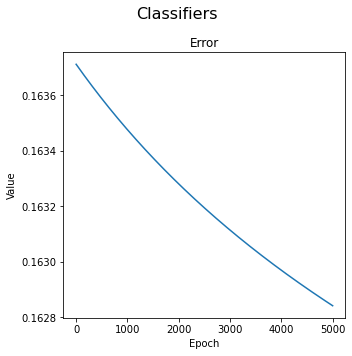

In [15]:
# Try to modify the code written for the XOR function to solve the previous classification problem
import matplotlib.pyplot as plt

learning_rate = 0.001
err_val = []

num_epochs = 5000

for epoch in range(num_epochs):
    output, H = Forward(X, W1, B1, W2, B2)
    
    W2 += learning_rate * diff_W2(H, Z, output).T
    B2 += learning_rate * diff_B2(Z, output)
    W1 += learning_rate * diff_W1(X, H, Z, output, W2).T
    B1 += learning_rate * diff_B1(Z, output, W2, H)
    
    # Cross entropy function
    error = np.mean(-(Z*np.log(output)))
    err_val += [error]

fig, ax1 = plt.subplots(1,1,figsize=(5,5))
fig.suptitle('Classifiers', fontsize=16)

ax1.plot(err_val)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.set_title('Error')

fig.tight_layout()
plt.show()

In [27]:
# We use three points to see if the outcome is the expected one: one point that very likely
# belongs to class A, one that surely belongs to class B, and one that might belong to either

X_Test1 = 0.01*np.ones([1,2])
X_Test2 = 7.5*np.ones([1,2])
X_Test3 = 4.5*np.ones([1,2])
Y_Test1, H_Test1 = Forward(X_Test1, W1, B1, W2, B2)
Y_Test2, H_Test2 = Forward(X_Test2, W1, B1, W2, B2)
Y_Test3, H_Test3 = Forward(X_Test3, W1, B1, W2, B2)

print(f'First Test: {Y_Test1[0,:]}')
print(f'Second Test: {Y_Test2[0,:]}')
print(f'Third Test: {Y_Test3[0,:]}')

First Test: [0.84400258 0.15599742]
Second Test: [4.47269142e-10 1.00000000e+00]
Third Test: [0.76656153 0.23343847]
